In [1]:
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt

# Study of the Wiener Process

In [2]:
def simulate_wiener_process(T:float=1, N:int=1_000)->np.ndarray:
    """
    Simulates a standard Wiener process (Brownian Motion).
    """
    dt = T / N
    t = np.linspace(0, T, N)

    dW = np.sqrt(dt) * np.random.normal(size=N)
#     dW = np.random.normal(mu*dt, sigma*np.sqrt(dt), N)

    W = np.cumsum(dW)
    # Prepend the initial value W(0) = 0
    W = np.insert(W, 0, 0)
    return t, W[:-1] # After insert 0 as first element array length is N+1


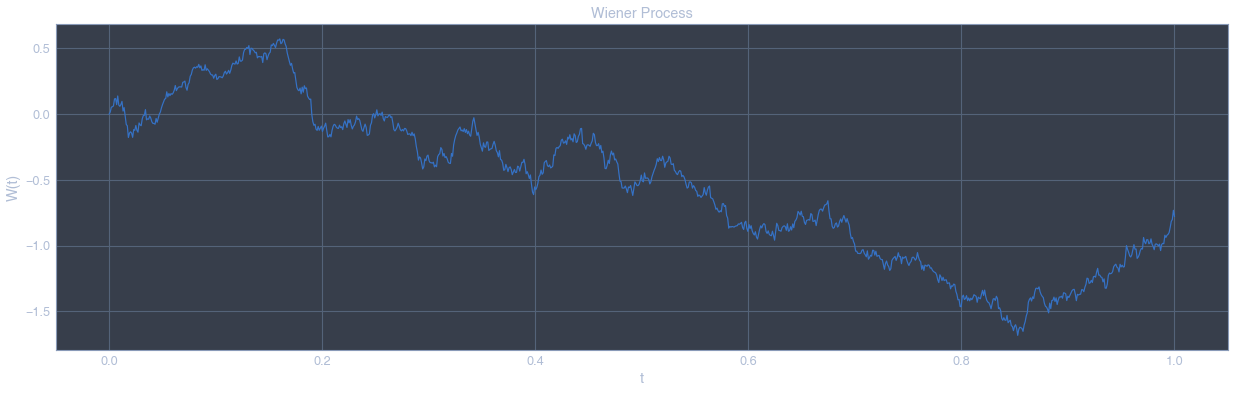

In [44]:
t, W = simulate_wiener_process()

plt.figure(figsize=(21, 6))
plt.plot(t, W)
plt.title('Wiener Process')
plt.xlabel('t')
plt.ylabel('W(t)');

## Means and STDs

In [13]:
means = []
stds = []
for _ in range(1_000):
    t, W = simulate_wiener_process()
    means.append(np.mean(W))
    stds.append(np.std(W))
    
np.mean(means), np.std(stds)

(0.03491672267143795, 0.15009699201974794)

Text(0.5, 1.0, 'STDs distribution')

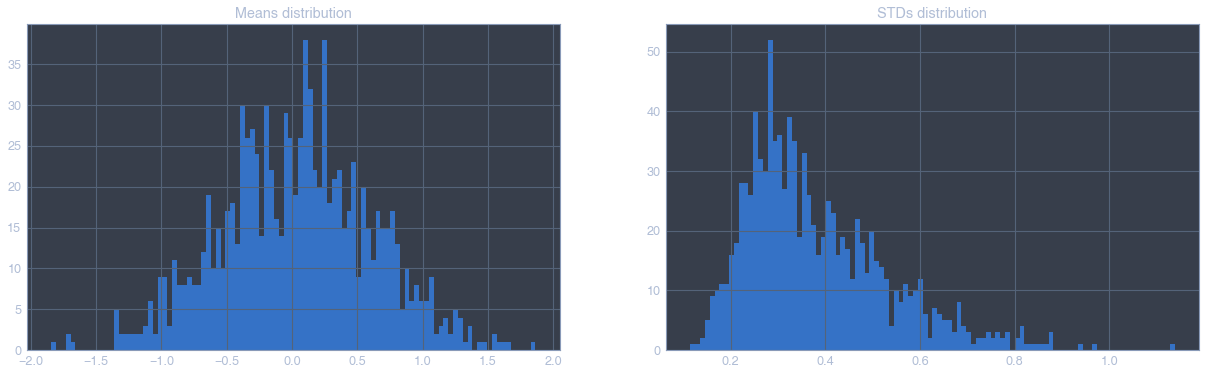

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(21, 6))
ax[0].hist(means, bins=100)
ax[0].set_title('Means distribution')
ax[1].hist(stds, bins=100)
ax[1].set_title('STDs distribution')

## Independence of Increments

p-value: 0.768


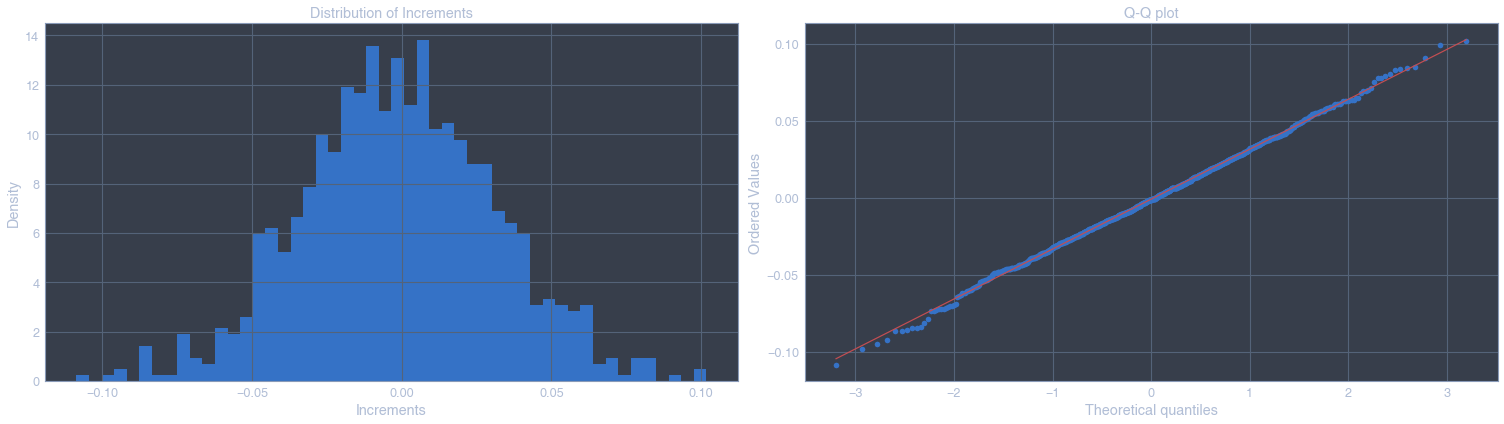

In [10]:
t, W = simulate_wiener_process()
increments = np.diff(W)

k2, p_value = stats.normaltest(increments)
print(f'p-value: {p_value:.3f}')

fig, ax = plt.subplots(1, 2, figsize=(21, 6))
ax[0].hist(increments, bins=50, density=True)
ax[0].set_title('Distribution of Increments')
ax[0].set_xlabel('Increments')
ax[0].set_ylabel('Density')

stats.probplot(increments, dist='norm', plot=ax[1])
ax[1].set_title('Q-Q plot')

fig.tight_layout()

Text(0.5, 1.0, 'P-values distribution')

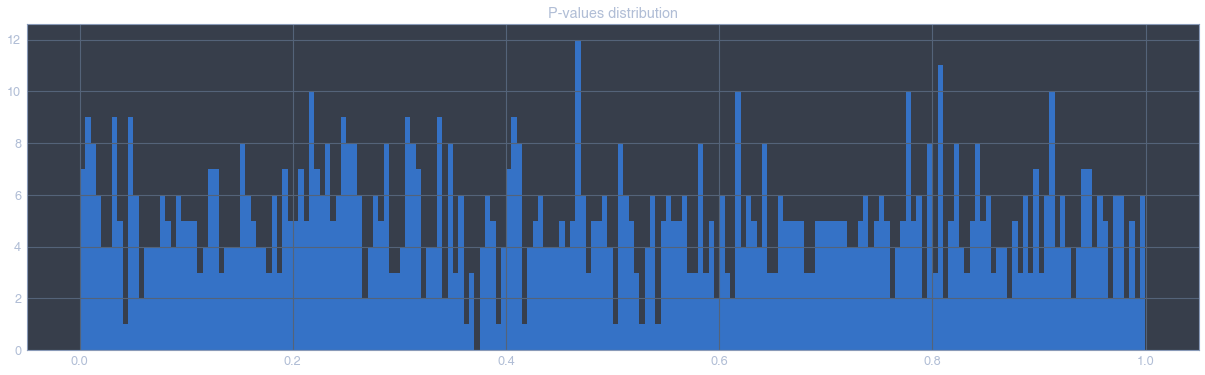

In [15]:
p_vals = []
for _ in range(1_000):
    t, W = simulate_wiener_process()
    increments = np.diff(W)
    _, p_value = stats.normaltest(increments)
    p_vals.append(p_value)

plt.figure(figsize=(21, 6))
plt.hist(p_vals, bins=200)
plt.title('P-values distribution')

## the Variance is Proportional to Time

Time t=0.1: emp. variance=0.1045, theor. variance=0.1000
Time t=0.5: emp. variance=0.5040, theor. variance=0.5000
Time t=1.0: emp. variance=0.9562, theor. variance=1.0000
Time t=2.0: emp. variance=2.0617, theor. variance=2.0000


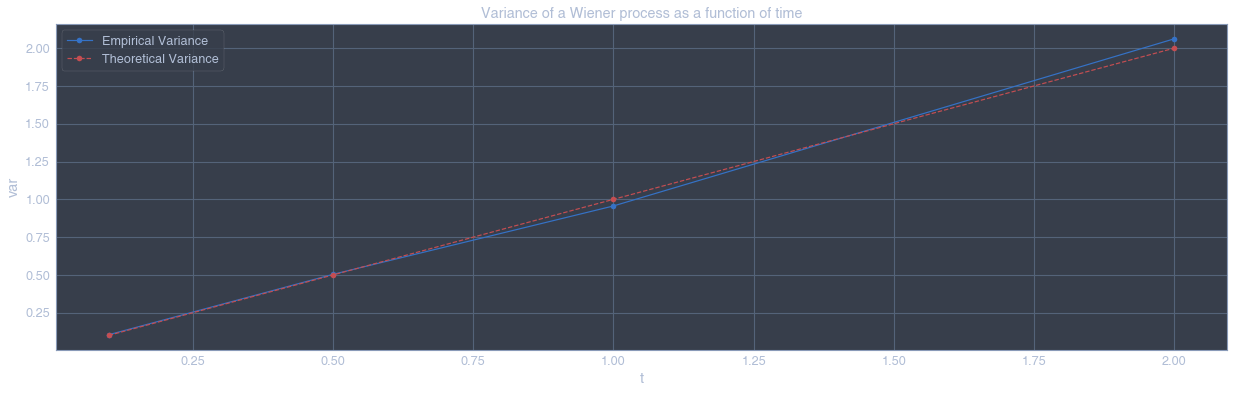

In [3]:
time_points = [0.1, 0.5, 1.0, 2.0]
num_simulations = 1_000

variances = []
theoretical_variances = []
for t in time_points:
    values_at_t = []
    for _ in range(num_simulations):
        N = int(t*1000)
        _, W = simulate_wiener_process(t, N)
        values_at_t.append(W[-1])

    empirical_variance = np.var(values_at_t)
    theoretical_variance = t

    variances.append(empirical_variance)
    theoretical_variances.append(theoretical_variance)

    print(f'Time t={t}: emp. variance={empirical_variance:.4f}, theor. variance={theoretical_variance:.4f}')

plt.figure(figsize=(21, 6))
plt.plot(time_points, variances, 'bo-', label='Empirical Variance')
plt.plot(time_points, theoretical_variances, 'ro--', label='Theoretical Variance')
plt.xlabel('t')
plt.ylabel('var')
plt.title('Variance of a Wiener process as a function of time')
plt.legend()


## Scalling

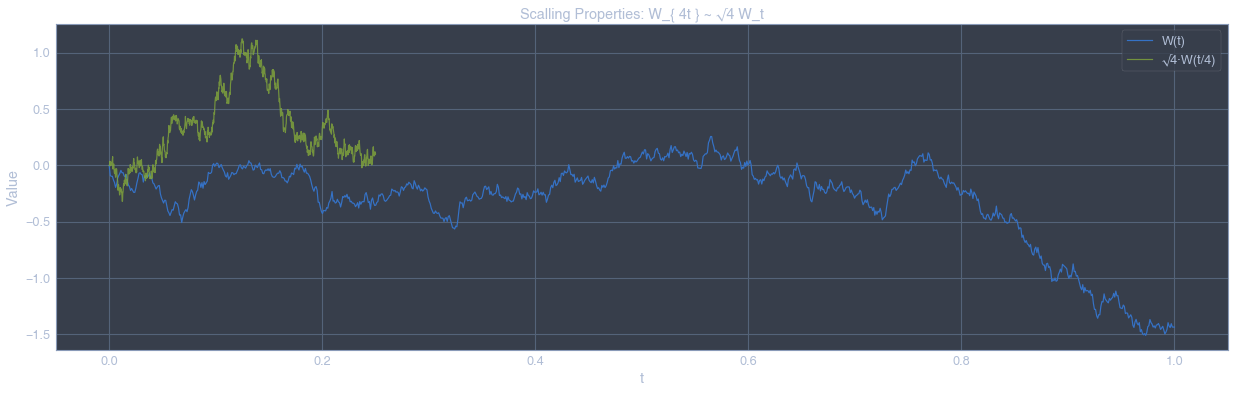

In [7]:
"""Демонстрация масштабирующего свойства: W_{at} ~ √a W_t"""
T = 1.0
N = 1000
a = 4

_, W_original = simulate_wiener_process(T, N)

t_scaled = np.linspace(0, T/a, N)
W_scaled = simulate_wiener_process(T/a, N)[1] * np.sqrt(a)

plt.figure(figsize=(21, 6))
plt.plot(np.linspace(0, T, N), W_original, label='W(t)')
plt.plot(t_scaled, W_scaled, label=f'√{a}·W(t/{a})', alpha=0.8)
plt.xlabel('t')
plt.ylabel('Value')
plt.title(f'Scalling Properties: W_{{ {a}t }} ~ √{a} W_t')
plt.legend()


## Stock Price

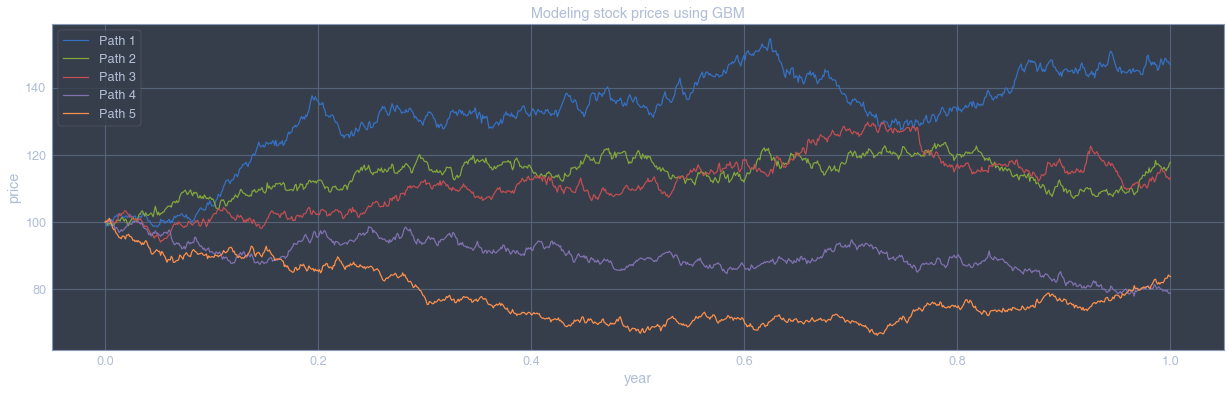

In [3]:
def geometric_brownian_motion(S0, mu, sigma, T, N):
    """
    Geometric Brownian motion model of stock prices
    dS = μS dt + σS dW
    """
    dt = T / N
    t = np.linspace(0, T, N)
    
    _, W = simulate_wiener_process(T, N)
    S = S0 * np.exp((mu - 0.5 * sigma**2)*t + sigma*W)
    
    return t, S

S0 = 100    # Starting price
mu = 0.05   # Drift (5% per annum)
sigma = 0.2 # Volatility (20% годовых)
T = 1.0     # 1 year

plt.figure(figsize=(21, 6))
for i in range(5):
    t, S = geometric_brownian_motion(S0, mu, sigma, T, 1000)
    plt.plot(t, S, label=f'Path {i+1}')

plt.xlabel('year')
plt.ylabel('price')
plt.title('Modeling stock prices using GBM')
plt.legend()

## Composite process

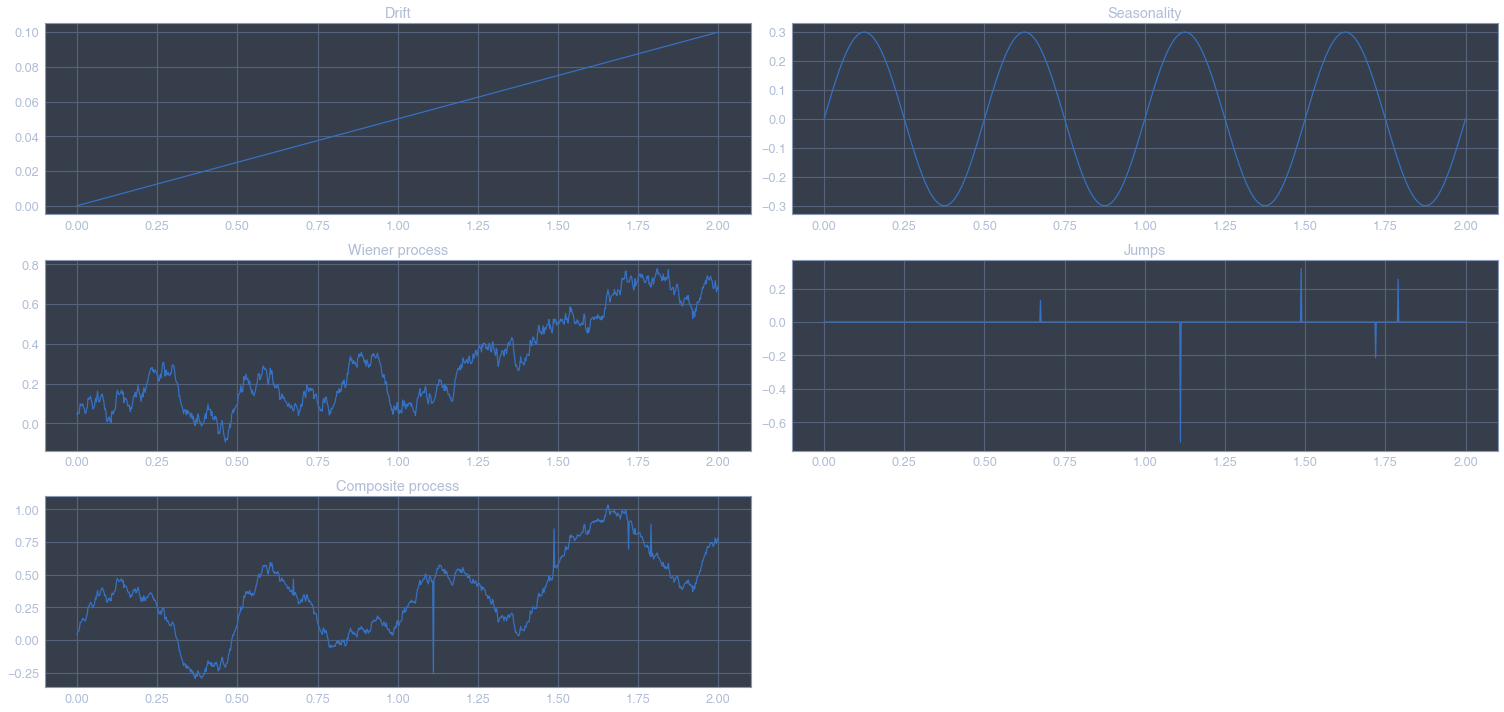

In [10]:
def composite_process(T, N):
    """
    Композитный процесс: дрейф + сезонность + винеровский процесс + скачки
    """
    dt = T / N
    t = np.linspace(0, T, N)
    
    # Components
    drift = 0.05 * t
    seasonal = 0.3 * np.sin(4 * np.pi * t)
    
    # Wiener process
    dW = np.random.normal(0, np.sqrt(dt), N)
    wiener = 0.4 * np.cumsum(dW)
    
    # Jumps (редкие большие движения)
    jumps = np.zeros(N)
    jump_indices = np.random.choice(N, size=5, replace=False)  # 5 random jumps
    jumps[jump_indices] = np.random.normal(0, 0.5, 5)
    
    # Composite process
    composite = drift + seasonal + wiener + jumps

    components = [drift, seasonal, wiener, jumps, composite]
    names = ['Drift', 'Seasonality', 'Wiener process', 'Jumps', 'Composite process']
    
    plt.figure(figsize=(21, 10))
    for i, (comp, name) in enumerate(zip(components, names)):
        plt.subplot(3, 2, i+1)
        plt.plot(t, comp);
        plt.title(name)
        plt.grid(True)

    plt.tight_layout()
    
    return composite

c_process = composite_process(2.0, 1000)

## Imitation of Multifractality

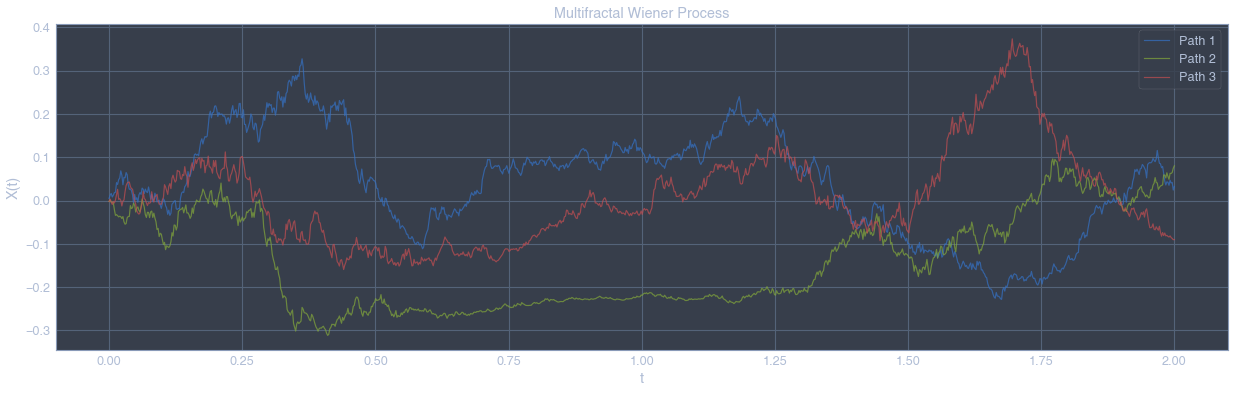

In [4]:
def multifractal_wiener(T, N, num_paths=3):
    """
    Винеровский процесс с изменяющейся во времени волатильностью
    для создания мультифрактальных свойств
    """
    dt = T / N
    t = np.linspace(0, T, N)
    
    plt.figure(figsize=(21, 6))
    for path_num in range(num_paths):
        # wiener process
        dW = np.random.normal(0, np.sqrt(dt), N)
        
        # changing volatility
        timescale_volatility = 0.2 + 0.15 * np.sin(5*t) * np.exp(-0.5*t)
        stochastic_volatility = 0.1*np.cumsum(dW)
        
        total_volatility = timescale_volatility + stochastic_volatility
        
        # modified increments
        modified_dW = total_volatility * dW
        X = np.cumsum(modified_dW)
        
        plt.plot(t, X, alpha=0.7, label=f'Path {path_num+1}')
    
    plt.xlabel('t')
    plt.ylabel('X(t)')
    plt.title('Multifractal Wiener Process')
    plt.legend()
    plt.grid(True)

multifractal_wiener(T=2.0, N=1000)